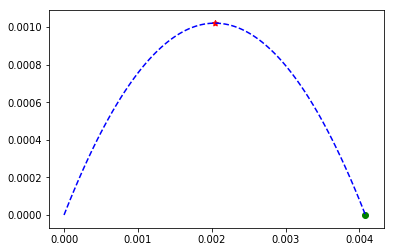

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 25 16:49:49 2018
@author: 1203087
"""

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

tf.set_random_seed(1)
np.random.seed(1)

# fake data
vel   = np.random.random(size=100000)
theta = np.random.random(size=100000)
inputs = np.stack((vel, theta), axis=-1)
#print(inputs.shape)
#print(vel)
#print('This is input')
#print(inputs[:,0] )

r    = vel*vel*np.sin(2.0*np.radians(theta*90.0)) / 9.8
h    = vel*vel*np.sin(np.radians(theta*90.0))*np.sin(np.radians(theta*90.0)) / 19.6
ans = np.stack((r, h), axis=-1)
#print(vel[10],theta[10],r[10],h[10])

def f(v, th, x):
    return np.tan(np.radians(th*90.0)) * x - 4.9 * x * x / (v * v * np.cos(np.radians(th*90.0)) * np.cos(np.radians(th*90.0)))

def hrange(v , th):
    return v*v*np.sin(2.0*np.radians(th*90.0)) / 9.8

def heigh(v , th):
    return v*v*np.sin(np.radians(th*90.0))*np.sin(np.radians(th*90.0)) / 19.6

x = np.linspace(0, hrange(0.2 , 0.5), 100)
plt.plot(x, f(0.2 , 0.5, x), 'b--')
plt.scatter(0.5*hrange(0.2 , 0.5), heigh(0.2 , 0.5),c='r',marker=(5, 1))
plt.scatter(hrange(0.2 , 0.5), 0,c='g')
##plt.annotate('max', xy=(0.5*hrange(2 , 45), heigh(2 , 45)), xytext=(1.5, -1.5), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

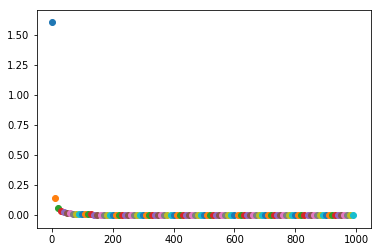

In [2]:
with tf.variable_scope('Inputs', reuse=True):
    tf_inputs = tf.placeholder(tf.float32, [None, 2], name='inputs')

with tf.variable_scope('Ans', reuse=True):
    tf_ans = tf.placeholder(tf.float32, [None, 2], name='answers')

with tf.variable_scope('Net', reuse=None):
    l1 = tf.layers.dense(tf_inputs, 5, tf.nn.relu, name='hidden_layer1')
    l1_BN = tf.layers.batch_normalization(inputs=l1, training=True, name='batch_normalization_layer1')
    l2 = tf.layers.dense(l1_BN, 5, tf.nn.relu, name='hidden_layer2')
    l2_BN = tf.layers.batch_normalization(inputs=l2, training=True, name='batch_normalization_layer2')
    output = tf.layers.dense(l2_BN, 2, name='output_layer')

    # add to histogram summary
    tf.summary.histogram('h1_out', l1)
    tf.summary.histogram('h2_out', l2)
    tf.summary.histogram('pred', output)

loss = tf.losses.mean_squared_error(tf_ans, output, scope='loss')

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)

tf.summary.scalar('loss', loss)     # add loss to scalar summary

sess = tf.Session()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter('./log', sess.graph)     # write to file
merge_op = tf.summary.merge_all() # operation to merge all summary

saver = tf.train.Saver()  # define a saver for saving and restoring
plt.ion()
plt.show()
for step in range(1000):
    # train and net output
    _, l, pred = sess.run([train_op, loss, output], {tf_inputs: inputs, tf_ans: ans})
    if step % 10 == 0:
        # plot and show learning process
        #print('step: ', step, 'loss: ', l)
        plt.scatter(step,l)
        plt.pause(0.1)

saver.save(sess, './params', write_meta_graph=False)

plt.ioff()

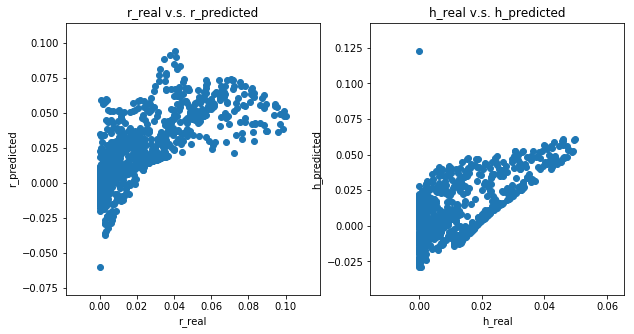

In [3]:
plt.figure(1, figsize=(10, 5))
plt.subplot(121)
plt.scatter(r, pred[:,0] )
plt.title('r_real v.s. r_predicted')
plt.xlabel('r_real')
plt.ylabel('r_predicted')
plt.subplot(122)
plt.scatter(h, pred[:,1] )
plt.title('h_real v.s. h_predicted')
plt.xlabel('h_real')
plt.ylabel('h_predicted')
plt.show()

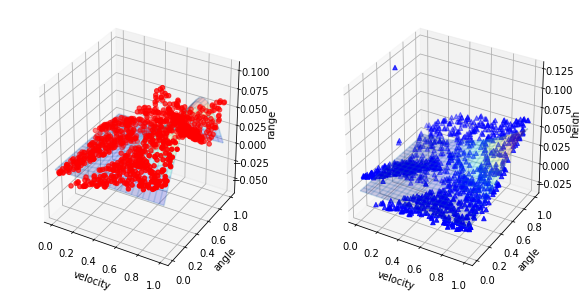

In [4]:
fig = plt.figure(1, figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = np.arange(0, 1, 0.01)
Y = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(X, Y)
R = hrange(X, Y)
H = heigh(X, Y)
ax.plot_wireframe(X, Y, R, rstride=5, cstride=5, alpha=0.2)
ax.plot_surface(X, Y, R, rstride=5, cstride=5, alpha=0.2,cmap=cm.jet)
#print(vel.shape, theta.shape, r.shape)

ax.scatter(vel, theta, pred[:,0], c='r', marker='o')

ax.set_xlabel('velocity')
ax.set_ylabel('angle')
ax.set_zlabel('range')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_wireframe(X, Y, H, rstride=5, cstride=5, alpha=0.2)
ax.plot_surface(X, Y, H, rstride=5, cstride=5, alpha=0.2,cmap=cm.jet)
ax.scatter(vel, theta, pred[:,1], c='b', marker='^')

ax.set_xlabel('velocity')
ax.set_ylabel('angle')
ax.set_zlabel('heigh')

plt.show()